# **PGM homework**: IWAE for binarised MNIST

In this assignment, you'll play a bit with a VAE on a binarised version of MNIST

## 1. Gaussian processes

### 1. Learning

**Write a complete set of functions implementing the training GP step, i.e. the optimization in
$\theta$ of the (marginal) log-likelihood: $h(\theta) = log \: p(Y|X,\theta)$**

$$Y | X \sim \mathcal{N}(0_n, C_{\theta})$$

We get rid off elements that do not depend on $\theta$.

\begin{align*}
h(\theta) &= log \: p(Y|X, \theta)\\
&= log\left( \: \frac{1}{(2 \pi)^{n/2} |C_{\theta}|^{1/2}} \exp^{- \frac{1}{2}( \: Y^T C_{\theta}^{-1} Y \: )} \: \right)\\
&= -\frac{1}{2} log |C_{\theta}| - \frac{1}{2} ( \: Y^T C_{\theta}^{-1} Y \: )\\
&= -\frac{1}{2} log |K_{\theta} + \sigma^2 I| - \frac{1}{2} ( \: Y^T (K_{\theta} + \sigma^2 I)^{-1} Y \: )\\
\end{align*}

\begin{align*}
\theta = \underset{\theta}{argmax} \left[ -\frac{1}{2} log |K_{\theta} + \sigma^2 I| - \frac{1}{2} ( \: Y^T (K_{\theta} + \sigma^2 I)^{-1} Y \: ) \right]\\
\end{align*}


- How to compute $Y^T (K_{\theta} + \sigma^2 I)^{-1} Y$ ?
We are looking for $\alpha$ such that:
\begin{align*}
(K_{\theta} + \sigma^2 I)^{-1} Y &= \alpha\\
(K_{\theta} + \sigma^2 I) \alpha &= Y\\
L L^T \alpha &= Y\\
L \beta &= Y\\
\end{align*}
Where we use the Cholesky decomposition to express the covariance matrix $K_{\theta} + \sigma^2 I$.
Then we can find $\alpha$ looking for the solution to $L^T \alpha = \beta$ where $\beta$ is the solution to $L \beta = Y$.

- How to compute $|K_{\theta} + \sigma^2 I|$ ?
\begin{align*}
|K_{\theta} + \sigma^2 I| &= |L L^T|\\
&= |L| |L^T|\\
&= |L|^2\\
&= {\left(\prod_{i=1}^n L_{i,i}\right)}^2\\
&= \prod_{i=1}^n L_{i,i}^2\\
\end{align*}
Where we use that $L$ is a lower triangular matrix and $L^T$ is an upper triangular matrix. Thanks to determinant properties, we know that $|L| = |L^T|$ and that for any triangular matrix the determinant is the product of its diagonal elements.

Then, 
\begin{align*}
-\frac{1}{2} log |K_{\theta} + \sigma^2 I| - \frac{1}{2} ( \: Y^T (K_{\theta} + \sigma^2 I)^{-1} Y \: ) &= -\frac{1}{2} log \prod_{i=1}^n {L_{i,i}}^2 - \frac{1}{2} \: Y^T \alpha \:\\
&= - \sum_{i=1}^n log \: L_{i,i} - \frac{1}{2} \: Y^T \alpha \:\\
\end{align*}

Now, we want to compute the gradient with respect to $\theta_i$ of the log likelihood. 

\begin{align*}
\nabla_{\theta_l} h(\theta) &= \nabla_{\theta_l} \left( \: -\frac{1}{2} log |K_{\theta} + \sigma^2 I| - \frac{1}{2} \: Y^T \: (K_{\theta} + \sigma^2 I)^{-1} \: Y \: \right)\\
&= \nabla_{\theta_l} \left( - \sum_{i=1}^n log \: L_{i,i} - \frac{1}{2} \: Y^T \alpha \right)\\
\end{align*}

The Cholesky decomposition gives us that $L_{i,i} = \sqrt{(K_{\theta} + \sigma^2 I)_{i,i} - \sum_{k=1}^{i-1} {L_{i,k}}^2}$. In the above formula, $\theta$ appears in $L_{i,i}$ and in $\alpha$.

Also we have:

We know that $\nabla_{\theta} log |C_{\theta}| = \frac{\nabla_{\theta} |C_{\theta}|}{|C_{\theta}|} = \frac{|C_{\theta}| \: Tr(C_{\theta}^{-1} \: \nabla_{\theta} C_{\theta})}{|C_{\theta}|} = Tr(C_{\theta}^{-1} \: \nabla_{\theta} C_{\theta})$ and that $\nabla_{\theta} Y^T C_{\theta}^{-1} Y = - C_{\theta}^{-1} \: Y \: \nabla_{\theta}C_{\theta} \: Y^T \: C_{\theta}^{-1}$.

\begin{align*}
\nabla_{\theta_l} h(\theta) &= \nabla_{\theta_l} \left( \: -\frac{1}{2} log |C_{\theta}| - \frac{1}{2} \: Y^T \: C_{\theta}^{-1} \: Y \: \right)\\
&= -\frac{1}{2} \nabla_{\theta_l} log |C_{\theta}| - \frac{1}{2} \: \nabla_{\theta_l} (Y^T C_{\theta}^{-1} Y)\\
&= -\frac{1}{2} |C_{\theta}| \: Tr(C_{\theta}^{-1} \: \nabla_{\theta_l} C_{\theta}) + \frac{1}{2} \: C_{\theta}^{-1} \: Y \: \nabla_{\theta_l}C_{\theta} \: Y^T \: C_{\theta}^{-1}\\
\end{align*}

None of these two methods leads to a simple formula for the gradient. We don't have time to think about the implementation of the conjugate gradient so that we will use scipy to compute the conjugate gradient descent and find the optimal theta.

In [117]:
import numpy as np
import pandas as pds
from scipy.optimize import minimize
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from math import *

In [118]:
def exponential_quadratic_kernel(THETA, x_i, x_j):
  return THETA[0] * np.exp( - THETA[1] / 2 * np.linalg.norm(x_i - x_j)**2) + THETA[2] + THETA[3] * np.dot(x_i.T, x_j)

def matrix_kernel(THETA, X):
  n = X.shape[0]
  matrix = np.zeros((n,n))
  for row in range(n):
    for col in range(n):
      matrix[row,col] = exponential_quadratic_kernel(THETA, X[row], X[col])
  return matrix

def marginal_loglikelihood(THETA, X, Y):
  n = X.shape[0]
  K = matrix_kernel(THETA, X)
  L = np.linalg.cholesky( K + THETA[4]*np.eye(n) ) # THETA[4] = sigma_2
  beta = np.linalg.solve(L, Y) # solve L beta = Y <=> solve(L, Y)
  alpha = np.linalg.solve(L.T, beta) # solve L^T alpha = beta <=> solve(L^T, beta)
  marginal_log_likelihood = - np.sum( [np.log(L[i,i]) for i in range(n)] ) - np.dot(Y.T, alpha)/2
  return marginal_log_likelihood

### 2. Prediction

**Write a complete set of functions in R or Python implementing the prediction GP step, i.e. the prediction $\hat{y}$ for a new observation $x$.**

We have a gaussian process $$Y | X \sim \mathcal{N}(0_n, C_{\theta})$$

From properties of the gaussian distribution we then have the following prediction gaussian process step : $$y_{n+1} | Y_n, X_n \sim \mathcal{N}(k^T C_{\theta} Y_n, C_{\theta} - k^T C_{\theta}^{-1} k)$$

Therefore, to compute the prediction $\hat{y}$ of a new observation in input we use the mean of the above distribution. In other words, we use the kernel function computed between the new observation $x$ and the training observations, times the weight learned before that we denoted by $\alpha$.

In [119]:
# prediction step:

def prediction_step(optimal_theta, X_train, Y_train, test_input):

  n = X_train.shape[0]
  K = matrix_kernel(optimal_theta, X_train)
  L = np.linalg.cholesky( K + optimal_theta[4]*np.eye(n) ) # THETA[4] = sigma_2
  beta = np.linalg.solve(L, Y_train) # solve L beta = Y <=> solve(L, Y)
  alpha = np.linalg.solve(L.T, beta) # solve L^T alpha = beta <=> solve(L^T, beta)

  prediction = 0
  for input in range(n):
    prediction += alpha[input] * exponential_quadratic_kernel(optimal_theta, X_train[input], test_input)
  return prediction

### 3. Real data

**Learn the GP regression model on the first 75% part of the UScrimes.csv data set. The target is the
Murder variable. Use the model learned to predict the outputs of the remaining 25%. Compare the RSME
you obtain with the RMSE of a simple multivariate linear model for regression.**


**For the linear model, you can use existing packages. However, all the functions you implement should be
stand alone. You are allowed to rely on packages but not on the ones implementing directly solutions to the
questions. The source code should be handed in along with results**

In [120]:
DF = pds.read_csv("/content/UScrimes.csv")
DF.columns = [["State", "Murder", "Assault", "UrbanPop"]]
features = np.array(DF[["State", "Assault", "UrbanPop"]]) # shape n x p
n, p = features.shape
target = np.array(DF[["Murder"]]) # shape n x 1
DF.head()

,State,Murder,Assault,UrbanPop
0,Alabama,13.2,236,58
1,Alaska,10.0,263,48
2,Arizona,8.1,294,80
3,Arkansas,8.8,190,50
4,California,9.0,276,91


In [121]:
features = np.array(DF[["Assault","UrbanPop"]])
features = normalize(features, axis=0)

target = np.array(DF[["Murder"]])
target = normalize(target, axis=0)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.25)

In [122]:
# optimization step: conjugate gradient descent

theta_0 = np.array([0,0,0,0,1])

theta = minimize(fun = marginal_loglikelihood, x0 = theta_0, args = (X_train, y_train), method="CG")
theta.x

array([1.49200122e+06, 1.04415029e+05, 3.62788729e+05, 1.06478164e+03,
       1.82351855e+06])

In [123]:
# prediction step:

predicted_murder = []
for test_input in X_test:
  predicted_murder.append( prediction_step(theta.x, X_train, y_train, test_input) )

predicted_murder = np.array(predicted_murder).reshape(-1,1)

RMSE = sqrt( np.mean( (predicted_murder - y_test)**2 ) )
RMSE

0.09285750457028175

## 2. IWAE

# Loading useful stuff

In [124]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

# Loading MNIST and binarising it

In [125]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int64)
y_test =tf.cast(y_test, tf.int64)

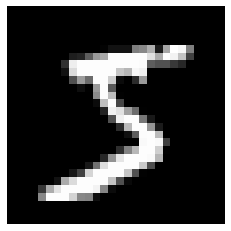

In [126]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

Then we binarise the data. There are many ways to do that. Here, we simply round the numbers, following the [TF tutorial on convolutional VAEs](https://www.tensorflow.org/tutorials/generative/cvae).

In [127]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

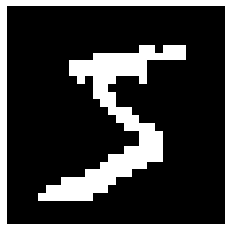

In [128]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

# Specifying our graphical model

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net. This neural net will be defined as a keras sequential model.

In [129]:
d = 10 # dimension of the latent space

p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

np.array( p_z.sample() )

array([ 1.6358532 ,  0.33898902,  0.5827557 , -1.0222918 ,  0.45605516,
        0.1429545 , -0.28240833,  1.659014  , -0.41079754,  0.29954264],
      dtype=float32)

In [130]:
h = 100 # number of hidden units

sigma = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(28*28)
])

pi_theta_z = np.array( decoder(np.array([p_z.sample()])) ).reshape((28,28))

Note that the decoder needs to output probabilities, which can be constrained using a sigmoid final layer. However, it is generally better (i.e. computationnaly more stable) to work with [logits](https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop) than probabilities, when doing deep learning. For instance, all the distributions of TensorFlow probability or Pytorch distributions that use probabilities as parameters (e.g. [Bernoulli](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli), [categorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) or [binomial](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Binomial)) can use $\texttt{logits}$ or $\texttt{probs}$ as arguments. It is generally better to use  $\texttt{logits}$. This is why this keras model for the decoder does not output probabilities, but logits.





### 1. Ancestral sampling

**1. Implement a function that performs ancestral sampling for this deep latent variable model, and show 5 sampled images from the initialised model. Of course, we expect these samples to look like random noise, since we have not trained our model yet.**

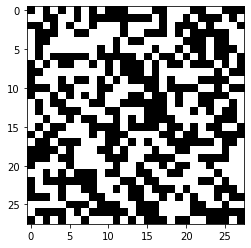

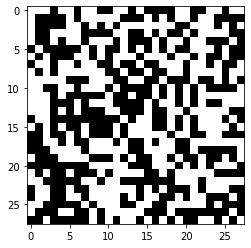

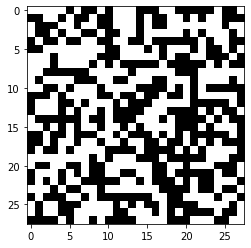

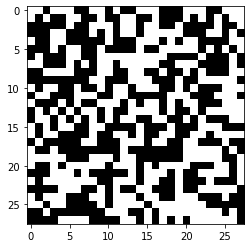

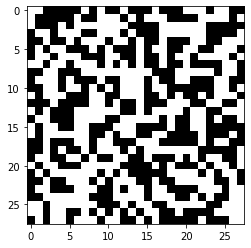

In [131]:
def ancestral_sampling(p_z, decoder):

  # sample z from the prior
  z = p_z.sample()

  # compute parameter for the bernoulli
  pi_theta_z = np.array( decoder(np.array([z])) ).reshape((28,28))

  # sample pixel from the bernoulli
  pixels_image = tfd.Bernoulli(logits = pi_theta_z).sample()
  plt.imshow( pixels_image, cmap='gray' )
  plt.show()

  return np.array(pixels_image)


for image in range(5):
  p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior
  decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[d,]),
    tfkl.Dense(h, activation=sigma),
    tfkl.Dense(h, activation=sigma),
    tfkl.Dense(28*28)
  ])
  ancestral_sampling(p_z, decoder)

## Encoder

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$ 
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [132]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(h, activation=sigma),
  tfkl.Dense(2*d) # 2*d because we need both the mean and the diagonal of the covariance of q(z|x)
])

##The IWAE objective

The **IWAE objective** is defined as
$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_{ik}){p(\mathbf{z}_{ik})}}{{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}_i)}} \right]
$$

### 2. Training

**2. Create a function that computes an unbiased estimate of the IWAE bound, and optimise it to train the model. You are allowed to use TF probability to avoid implementing the reparametrisation trick, and you are allowed to use keras for training.** 






...

### 3. Sampling

**3. Show a few samples from the model after training.**

...

### 4. Importance sampling and visualisation

**Implement a importance sampling estimate to approximate the posterior mean of each data point: $\mathbb{E}[z|x_i] = \int z \: p(z|x_i) \: dz$**


**Visualise these two-dimensional embeddings using a scatter plot.**

In [133]:
sample_size = 100

p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

posterior_mean = []

for image in range(len(train_images)):

  x = np.array([train_images[image]])
  mean, var = tf.reshape(encoder(x),[2,10])
  var = tf.exp(var/2)
  
  #z = tfd.Independent(tfd.Normal(loc = mean, scale = var),reinterpreted_batch_ndims=1)
  z = tfd.Normal(loc = mean, scale = var)
  z_samples = z.sample(sample_size)

  # p(z|x) = p_theta(x|z).p(z)
  theta = decoder(z_samples)
  log_p_theta_x_z = tf.reduce_sum( tfd.Bernoulli(theta).log_prob(x), axis=1 )

  # prior
  log_p_z = p_z.log_prob(z_samples)

  # q_gamma(z|x)
  log_q_gamma_z_x = tf.reduce_sum( z.log_prob(z_samples), axis=1 )

  ratio = tf.exp( log_p_theta_x_z + log_p_z - log_q_gamma_z_x - tf.reduce_logsumexp(log_p_theta_x_z + log_p_z - log_q_gamma_z_x) )

  posterior_mean.append( tf.reduce_sum( z_samples * np.array([ratio]).reshape(-1,1), axis=0) )


KeyboardInterrupt: ignored

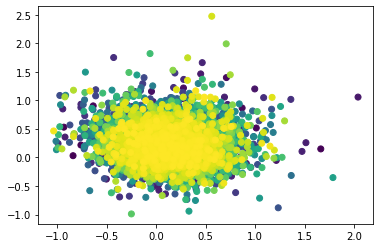

In [134]:
embedding_1 = np.array(posterior_mean)[:,0]
embedding_2 = np.array(posterior_mean)[:,1]

plt.scatter(embedding_1, embedding_2, c = np.arange(len(embedding_1)))

I interrupt the above cell because it was too long.

The visualization scatter plot capture the latent space distribution. During the training, we should be able to see some clusters appearing with increasing accuracy.